<a href="https://colab.research.google.com/github/praveenraghuvanshi1512/EVA4/blob/Session-4/Session-4/Assignment-4/EVA_4_Assignment_4_Praveen_Raghuvanshi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install pytorch and tochvision 
!pip install torch torchvision

In [2]:
!nvidia-smi

Tue Feb 11 14:33:45 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [17]:
# Import libraries
import pandas as pd
import numpy as np

# For reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline

# For creating validation set
from sklearn.model_selection import train_test_split

# from evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# Pytorch libraries and modules
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Module, Softmax, Dropout
from torch.optim import Adam, SGD
from torchvision import datasets, transforms, utils

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [0]:
# Constants and Hyperparameters
PATH_TO_STORE_TRAINSET = './data'
PATH_TO_STORE_TESTSET = './data'
input_size = 784
output_size = 10

num_epochs = 20
batch_size = 64
learning_rate = 0.001
random_seed = 1

In [0]:
# Transformations

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,)),
                                ])

In [12]:
# Load dataset
train_dataset = datasets.MNIST(root=PATH_TO_STORE_TRAINSET, train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root=PATH_TO_STORE_TESTSET,  train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_dataset,  batch_size=batch_size, shuffle=True)

print(len(train_dataset))
print(len(test_dataset))

60000
10000


torch.Size([64, 1, 28, 28])
torch.Size([64])


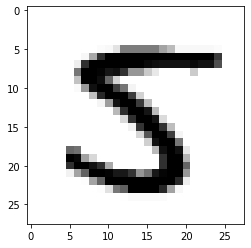

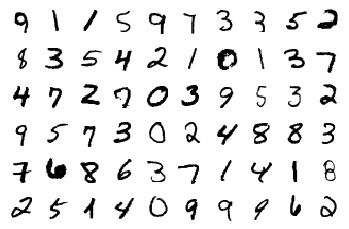

In [13]:
# Data Analysis
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Plot images
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
  plt.subplot(6, 10, index)
  plt.axis('off')
  plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [0]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv4 = nn.Conv2d(32, 16, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv5 = nn.Conv2d(16, 8, 3)
        self.conv6 = nn.Conv2d(8, 16, 3)
        self.conv7 = nn.Conv2d(16, 10, 3)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x)))))
        x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))
        x = F.relu(self.conv6(F.relu(self.conv5(x))))
        x = self.conv7(x)
        x = x.view(-1, 10)
        return F.log_softmax(x)

In [0]:
# initialize CNN, cost, and optimizer
model = Model()
model.to(device)
criterion = nn.NLLLoss()   # with log_softmax() as the last layer, this is equivalent to cross entropy loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [18]:
# Model summary
from torchsummary import summary
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
            Conv2d-2           [-1, 16, 28, 28]           1,168
         MaxPool2d-3           [-1, 16, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]           4,640
            Conv2d-5           [-1, 16, 14, 14]           4,624
         MaxPool2d-6             [-1, 16, 7, 7]               0
            Conv2d-7              [-1, 8, 5, 5]           1,160
            Conv2d-8             [-1, 16, 3, 3]           1,168
            Conv2d-9             [-1, 10, 1, 1]           1,450
Total params: 14,290
Trainable params: 14,290
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.25
Params size (MB): 0.05
Estimated Total Size (MB): 0.31
---------------------------------------------

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [19]:
# Training Time!
import time
import copy

# Some initialization work first...
train_losses, val_losses = [], []
train_accu, val_accu = [], []
start_time = time.time()
early_stop_counter = 10   # stop when the validation loss does not improve for 10 iterations to prevent overfitting
counter = 0
best_val_loss = float('Inf')

for e in tqdm(range(num_epochs)):
    epoch_start_time = time.time()
    running_loss = 0
    accuracy=0
    # training step
    model.train()
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        log_ps = model(images)
        
        ps = torch.exp(log_ps)                
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # record training loss and error, then evaluate using validation data
    train_losses.append(running_loss/len(train_loader))
    train_accu.append(accuracy/len(train_loader))
    val_loss = 0
    accuracy=0
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            log_ps = model(images)
            val_loss += criterion(log_ps, labels)

            ps = torch.exp(log_ps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor))
    val_losses.append(val_loss/len(test_loader))
    val_accu.append(accuracy/len(test_loader))

    print("Epoch: {}/{}.. ".format(e+1, num_epochs),
          "Time: {:.2f}s..".format(time.time()-epoch_start_time),
          "Training Loss: {:.3f}.. ".format(train_losses[-1]),
          "Training Accu: {:.3f}.. ".format(train_accu[-1]),
          "Val Loss: {:.3f}.. ".format(val_losses[-1]),
          "Val Accu: {:.3f}".format(val_accu[-1]))

#     print('Epoch %d / %d took %6.2f seconds' % (e+1, epochs, time.time()-epoch_start_time))
#     print('Total training time till this epoch was %8.2f seconds' % (time.time()-start_time))
    
    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        counter=0
        best_model_wts = copy.deepcopy(model.state_dict())
    else:
        counter+=1
        print('Validation loss has not improved since: {:.3f}..'.format(best_val_loss), 'Count: ', str(counter))
        if counter >= early_stop_counter:
            print('Early Stopping Now!!!!')
            model.load_state_dict(best_model_wts)
            break

  5%|▌         | 1/20 [00:14<04:33, 14.37s/it]

Epoch: 1/20..  Time: 14.36s.. Training Loss: 0.796..  Training Accu: 0.745..  Val Loss: 0.284..  Val Accu: 0.915


 10%|█         | 2/20 [00:28<04:17, 14.29s/it]

Epoch: 2/20..  Time: 14.09s.. Training Loss: 0.236..  Training Accu: 0.929..  Val Loss: 0.167..  Val Accu: 0.948


 15%|█▌        | 3/20 [00:42<04:02, 14.25s/it]

Epoch: 3/20..  Time: 14.15s.. Training Loss: 0.160..  Training Accu: 0.951..  Val Loss: 0.126..  Val Accu: 0.961


 20%|██        | 4/20 [00:56<03:46, 14.16s/it]

Epoch: 4/20..  Time: 13.96s.. Training Loss: 0.127..  Training Accu: 0.961..  Val Loss: 0.102..  Val Accu: 0.968


 25%|██▌       | 5/20 [01:11<03:33, 14.24s/it]

Epoch: 5/20..  Time: 14.44s.. Training Loss: 0.109..  Training Accu: 0.966..  Val Loss: 0.092..  Val Accu: 0.971


 30%|███       | 6/20 [01:24<03:18, 14.16s/it]

Epoch: 6/20..  Time: 13.98s.. Training Loss: 0.096..  Training Accu: 0.970..  Val Loss: 0.079..  Val Accu: 0.975


 35%|███▌      | 7/20 [01:38<03:03, 14.08s/it]

Epoch: 7/20..  Time: 13.88s.. Training Loss: 0.087..  Training Accu: 0.974..  Val Loss: 0.076..  Val Accu: 0.975


 40%|████      | 8/20 [01:52<02:48, 14.06s/it]

Epoch: 8/20..  Time: 13.99s.. Training Loss: 0.081..  Training Accu: 0.975..  Val Loss: 0.076..  Val Accu: 0.975
Validation loss has not improved since: 0.076.. Count:  1


 45%|████▌     | 9/20 [02:06<02:34, 14.03s/it]

Epoch: 9/20..  Time: 13.98s.. Training Loss: 0.076..  Training Accu: 0.977..  Val Loss: 0.058..  Val Accu: 0.982


 50%|█████     | 10/20 [02:21<02:20, 14.08s/it]

Epoch: 10/20..  Time: 14.17s.. Training Loss: 0.071..  Training Accu: 0.978..  Val Loss: 0.061..  Val Accu: 0.980
Validation loss has not improved since: 0.058.. Count:  1


 55%|█████▌    | 11/20 [02:34<02:06, 14.03s/it]

Epoch: 11/20..  Time: 13.92s.. Training Loss: 0.068..  Training Accu: 0.979..  Val Loss: 0.059..  Val Accu: 0.981
Validation loss has not improved since: 0.058.. Count:  2


 60%|██████    | 12/20 [02:49<01:52, 14.08s/it]

Epoch: 12/20..  Time: 14.19s.. Training Loss: 0.065..  Training Accu: 0.980..  Val Loss: 0.052..  Val Accu: 0.984


 65%|██████▌   | 13/20 [03:02<01:38, 14.00s/it]

Epoch: 13/20..  Time: 13.82s.. Training Loss: 0.062..  Training Accu: 0.981..  Val Loss: 0.051..  Val Accu: 0.984


 70%|███████   | 14/20 [03:17<01:24, 14.05s/it]

Epoch: 14/20..  Time: 14.15s.. Training Loss: 0.059..  Training Accu: 0.982..  Val Loss: 0.050..  Val Accu: 0.984


 75%|███████▌  | 15/20 [03:31<01:10, 14.01s/it]

Epoch: 15/20..  Time: 13.94s.. Training Loss: 0.057..  Training Accu: 0.982..  Val Loss: 0.055..  Val Accu: 0.982
Validation loss has not improved since: 0.050.. Count:  1


 80%|████████  | 16/20 [03:45<00:56, 14.06s/it]

Epoch: 16/20..  Time: 14.15s.. Training Loss: 0.056..  Training Accu: 0.983..  Val Loss: 0.046..  Val Accu: 0.984


 85%|████████▌ | 17/20 [03:59<00:41, 14.00s/it]

Epoch: 17/20..  Time: 13.87s.. Training Loss: 0.054..  Training Accu: 0.984..  Val Loss: 0.048..  Val Accu: 0.985
Validation loss has not improved since: 0.046.. Count:  1


 90%|█████████ | 18/20 [04:13<00:28, 14.06s/it]

Epoch: 18/20..  Time: 14.18s.. Training Loss: 0.051..  Training Accu: 0.984..  Val Loss: 0.047..  Val Accu: 0.985
Validation loss has not improved since: 0.046.. Count:  2


 95%|█████████▌| 19/20 [04:27<00:14, 14.05s/it]

Epoch: 19/20..  Time: 14.03s.. Training Loss: 0.050..  Training Accu: 0.985..  Val Loss: 0.048..  Val Accu: 0.985
Validation loss has not improved since: 0.046.. Count:  3


100%|██████████| 20/20 [04:41<00:00, 13.99s/it]

Epoch: 20/20..  Time: 13.85s.. Training Loss: 0.048..  Training Accu: 0.985..  Val Loss: 0.041..  Val Accu: 0.988


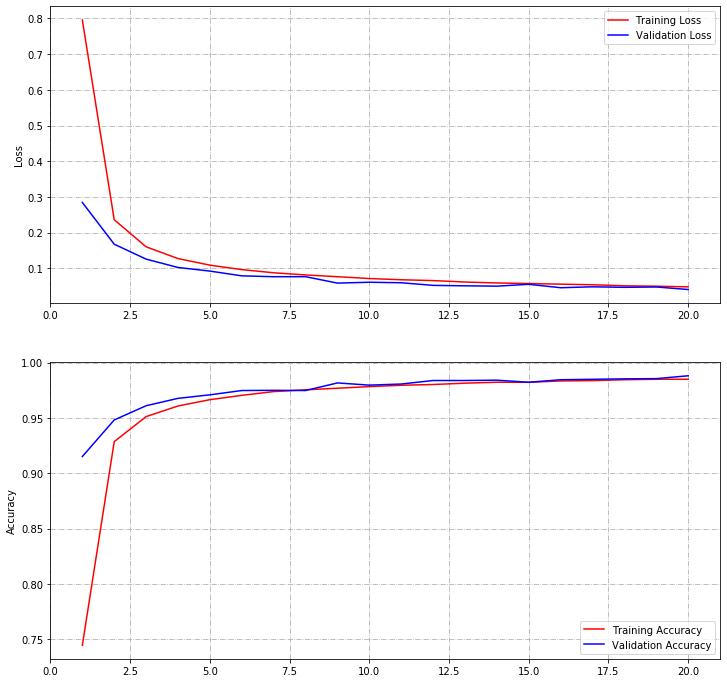

In [20]:
# plot training history
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
ax = plt.gca()
ax.set_xlim([0, e + 2])
plt.ylabel('Loss')
plt.plot(range(1, e + 2), train_losses[:e+1], 'r', label='Training Loss')
plt.plot(range(1, e + 2), val_losses[:e+1], 'b', label='Validation Loss')
ax.grid(linestyle='-.')
plt.legend()
plt.subplot(2,1,2)
ax = plt.gca()
ax.set_xlim([0, e+2])
plt.ylabel('Accuracy')
plt.plot(range(1, e + 2), train_accu[:e+1], 'r', label='Training Accuracy')
plt.plot(range(1, e + 2), val_accu[:e+1], 'b', label='Validation Accuracy')
ax.grid(linestyle='-.')
plt.legend()
plt.show()